## Setup Project
Import used packages


In [1]:
# import required libraries
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
from astropy.table import Table
import glob
import warnings
from sklearn import mixture
import itertools

Setup global plot settings

In [2]:

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(20,20)     #(6.0,4.0)
matplotlib.rcParams['font.size']=16                 #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Data entry and categorisation
Enter data file location and initiate variables

In [3]:

# import data from Data directory
allPointsFiles = glob.glob('../Data/*/*/points.txt')
allFuzzyFiles = glob.glob('../Data/*/*/fuzzy.txt')
allVaryingPointFiles = glob.glob('../Data/*/*/P*.csv')
allXrayFiles = glob.glob('../Data/XrayFlash.txt')
farPoints = []
midPoints = []
closePoints = []
variablePoints = []
xRayPoints = []
totalPoints = 0


### Categorise and process Points
Iterate through points files and categorize points into close and far points, where close points can be measured by parallax accurately.\
Convert to useful data types in process.\
points data format: [Name, x, y, parsec, HRx, Absolute magnitude, Apparent magnitude, Radial Velocity]

In [4]:
for j, pointsFile in enumerate(allPointsFiles):
    try:
        this = Table.read(pointsFile,format='ascii')
        totalPoints= totalPoints+len(this)
        thispar = this['par']
        thism0, thism1, thism2 = (np.log10(this['flux1']), 
                                  np.log10(this['flux2']), 
                                  np.log10(this['flux3']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        
        # transform coords onto "sky net" based on file path and store in numpy array          
        if pointsFile.rfind('Up')!=-1:
            points = np.array([this['name'], this['y'], -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Front')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Right')!=-1:
            points = np.array([this['name'], this['x'], this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Back')!=-1:
            points = np.array([this['name'], this['x']+90, this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Left')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+180, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Down')!=-1:
            points = np.array([this['name'], this['y'], -this['x']-90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
            
        # sort into close and far
        for point in points:
            if float(point[3]) > 0.01:
                closePoints.append(point)
            elif float(point[3]) < 0.007:# value chosen to minimize clusters being assigned to mid distance
                farPoints.append(point)   
            else:
                midPoints.append(point)  
    except:
        pass
closePointsNumpy=np.array(closePoints)
midPointsNumpy=np.array(midPoints)
farPointsNumpy=np.array(farPoints)

### Categorise Fuzzies
A similar process as used on the points data

### Categorise Xray flashes


In [5]:
for j, XrayFiles in enumerate(allXrayFiles):
    try:
        this = Table.read(XrayFiles,format='ascii')
        for line in this:
            # transform coords onto "sky net" based on file path and store in numpy array          
            if line['Camera']==('Up'):
                Xrays = np.array([line['y'], -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Front'):
                Xrays = np.array([ line['y']-90, -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Right'):
                Xrays = np.array([ line['x'], line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Back'):
                Xrays = np.array([line['x']+90, line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Left'):
                Xrays = np.array([ line['y']-90, -line['x']+180, line['mag']]).T.tolist()
            elif line['Camera']==('Down'):
                Xrays = np.array([ line['y'], -line['x']-90, line['mag']]).T.tolist()

            xRayPoints.append(Xrays)
    except:
        pass
xRayPointsNumpy=np.array(xRayPoints)

## Check IO
A star map to check all are present, a benchmark HR diagram and a cluster map.

### HR benchmark

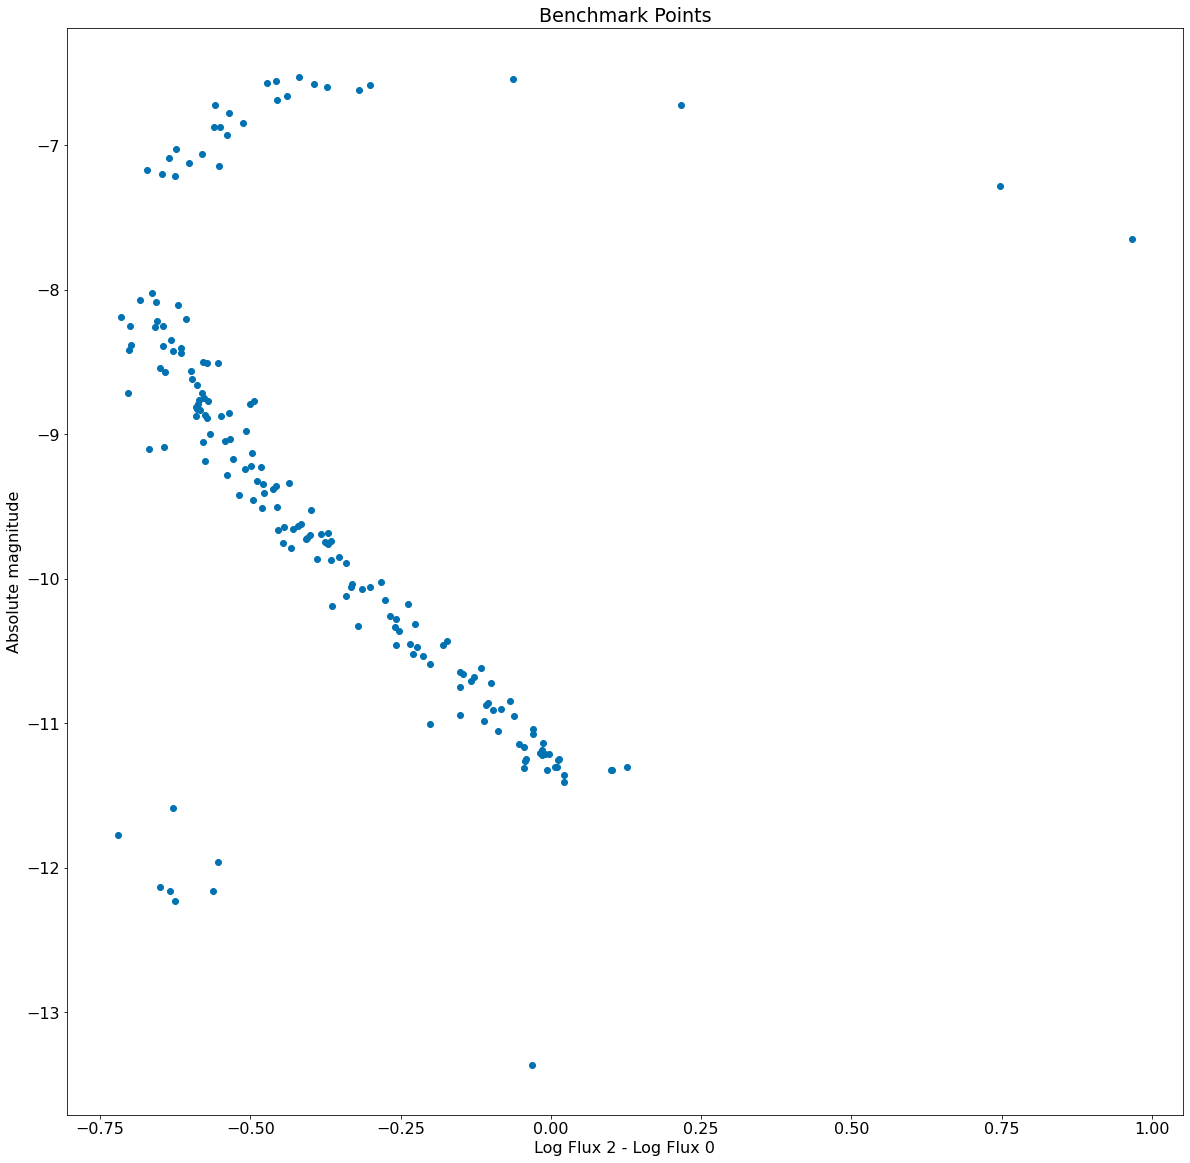

In [6]:

# figure for HR diagram benchmark
figHRBenchMark = plt.figure()
plt.ylabel('Absolute magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('Benchmark Points')
plt.scatter((closePointsNumpy.T)[4].astype(np.float),(closePointsNumpy.T)[5].astype(np.float))


### Sky Net

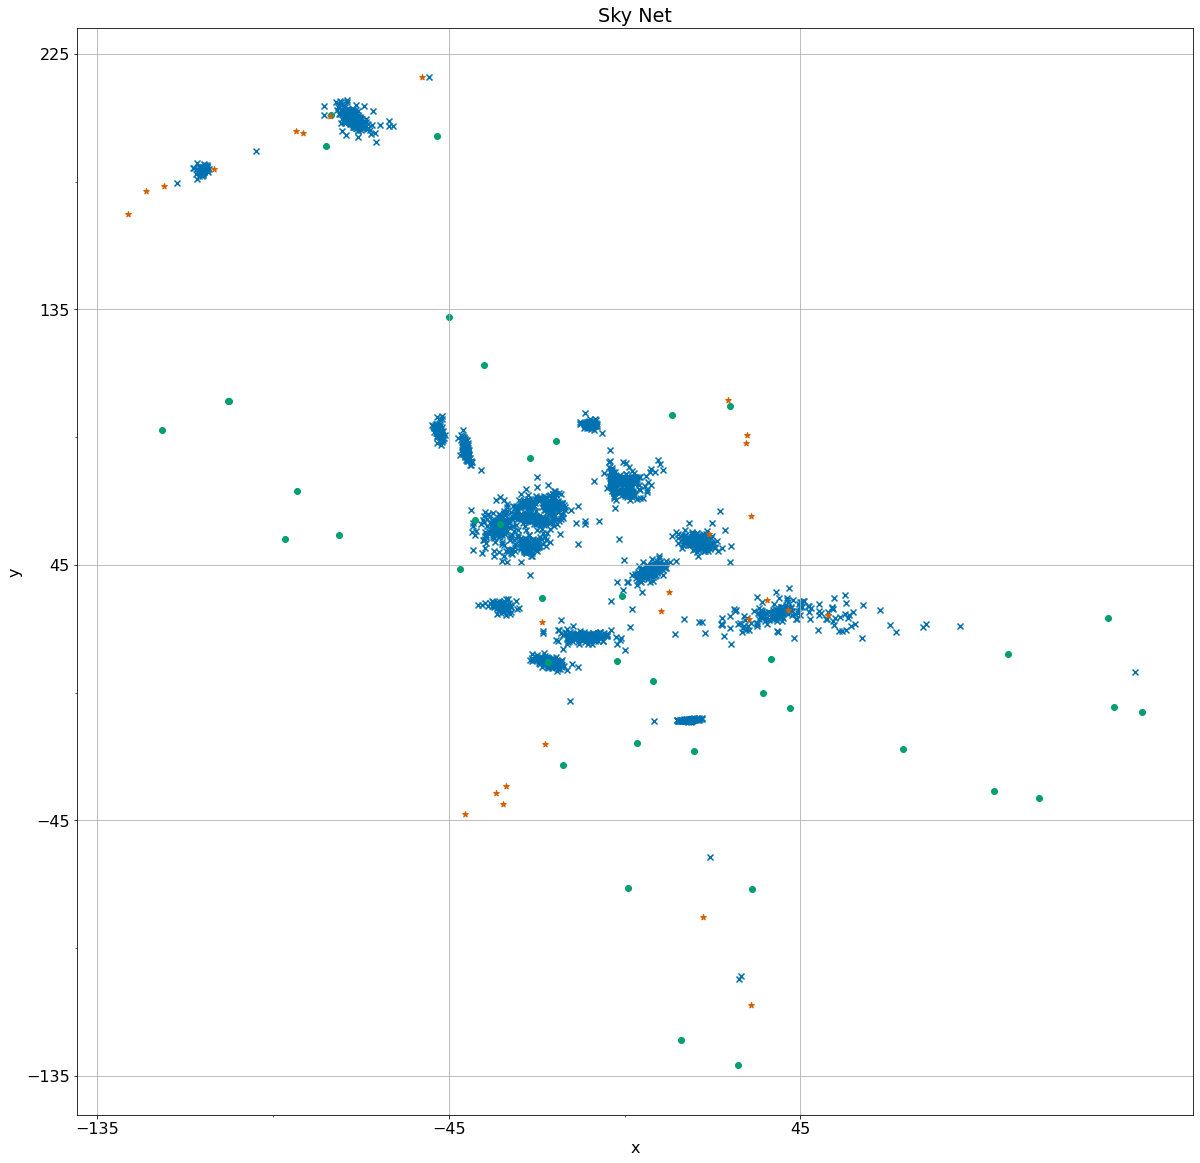

In [7]:
# figure for HR diagram benchmark
skyNet= plt.figure()
ax = skyNet.add_subplot(1, 1, 1)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Sky Net')
plt.scatter((farPointsNumpy.T)[1].astype(np.float),(farPointsNumpy.T)[2].astype(np.float), marker = 'x')
plt.scatter((xRayPointsNumpy.T)[0].astype(np.float),(xRayPointsNumpy.T)[1].astype(np.float), marker = 'o')
plt.scatter((midPointsNumpy.T)[1].astype(np.float),(midPointsNumpy.T)[2].astype(np.float), marker = '*')
yticksMajor = [-135,-45,45,135,225]
yticksMinor = [-90,0,90,180]
xticksMajor = [-135,-45,45]
xticksMinor = [-90,0]

ax.set_xticks(xticksMajor)
ax.set_yticks(yticksMajor)
ax.set_xticks(xticksMinor, minor=True)
ax.set_yticks(yticksMinor, minor=True)
plt.grid()

## Cluster processing
Process:
- Use x, y, HRx and HRy in a gaussian mixture clustering to fit dwarfs, main and giant sequence groups separately in each cluster.
    - Use Scikit-learn gaussian mixture function to calculate cluster distribution and optimise cluster count to minimise AIC and BIC.
- Take largest data set from each cluster to be the main sequence cluster and fit to HR benchmark
- Distinguish between dwarf and giant groups using average HR x-axis values
- Match dwarf and giant groups to main sequence groups via their position in magnitude sorted local cluster list
- Mombine dwarf, main and giant groups for each cluster
- Fit to benchmark HR in order of most to least isolated clusters, adding clusters to benchmark HR each time.
    - Generate dummy points using scikit-learn gaussian mixture to compare clusters goodness of fit.


### Create Prototype HR diagram template

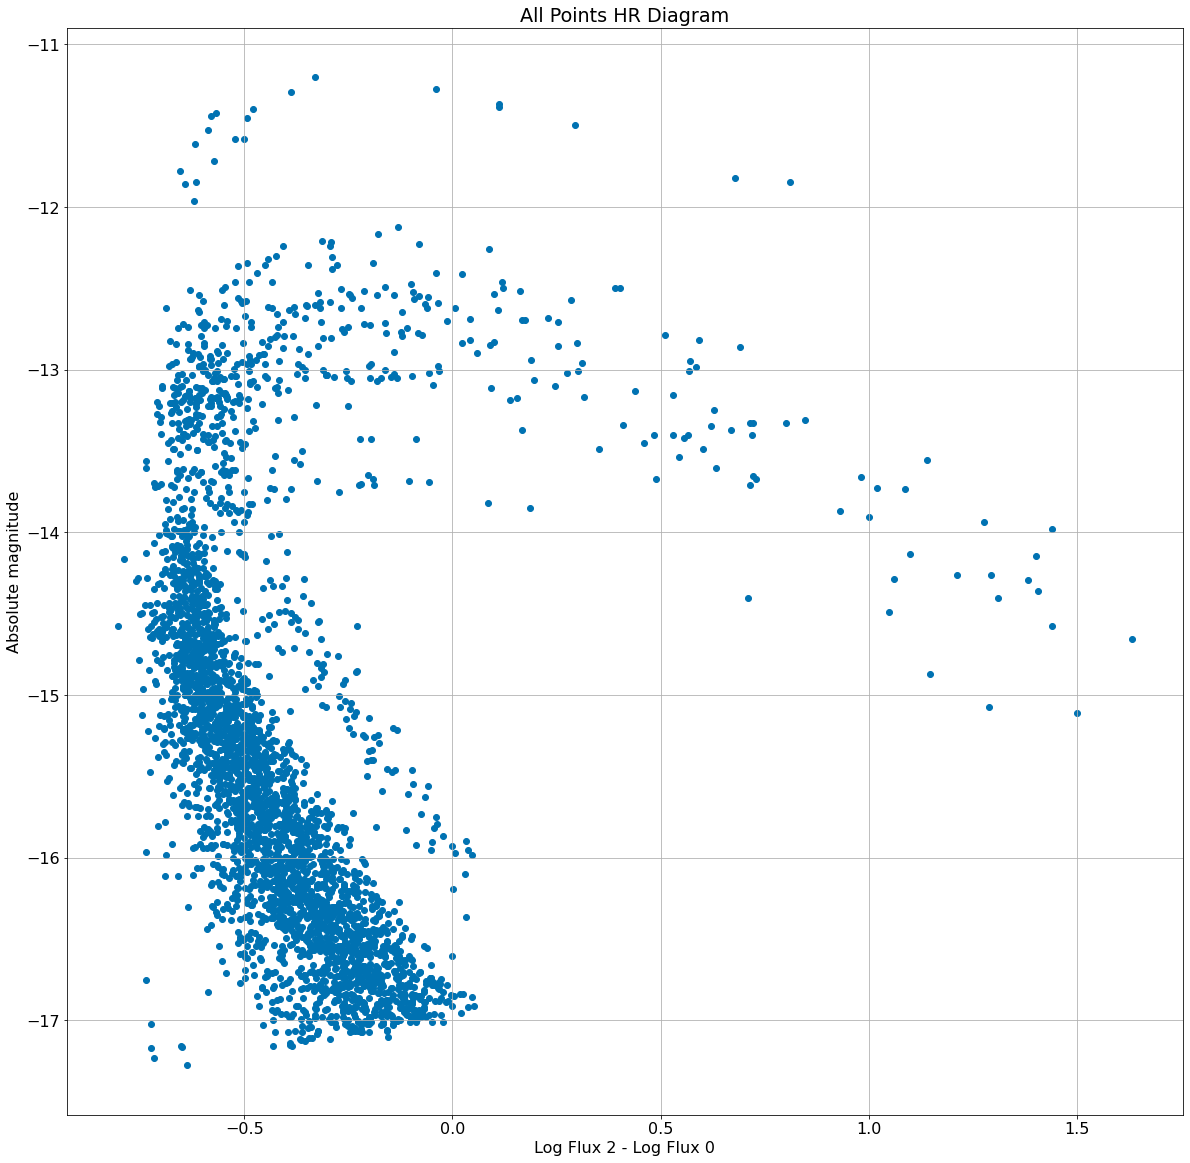

In [8]:
#prep data

figHRPreview = plt.figure()
#allPoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,5]],midPointsNumpy[:,[4,6]],farPointsNumpy[:,[4,6]]))).astype(np.float)
# allPoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,5]],midPointsNumpy[:,[4,5]]))).astype(np.float)
allPoints_HRfloats=farPointsNumpy[:,[4,6]].astype(np.float)
# figure for HR diagram Template
plt.ylabel('Absolute magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('All Points HR Diagram')
plt.scatter((allPoints_HRfloats.T)[0].astype(np.float),(allPoints_HRfloats.T)[1].astype(np.float))
plt.grid()

In [13]:
## parameters
tol=0.001 # plateau flatness tolerance
reqMinAge=10 # number of counts needed to confidently declare global minimum

BICs=[np.infty]
shapeCount = 1
HRModel = mixture.GaussianMixture(n_components=shapeCount, covariance_type='full',n_init = 5)
HRModel.fit(allPoints_HRfloats)
minAge=0
while minAge<reqMinAge:
    BIC=HRModel.bic(allPoints_HRfloats)
    if BIC<min(BICs):
        minAge=0
    else:
        minAge=minAge+1
    BICs.append(BIC)
    shapeCount=shapeCount+1
    HRModel = mixture.GaussianMixture(n_components=shapeCount, covariance_type="full",n_init = 5)
    HRModel.fit(allPoints_HRfloats)
    
# select shapeCount
BICs.pop(0)
minBIC = min(BICs)
shapeCount = [i for i, e in enumerate(BICs) if e < (minBIC*(1+tol))][0]+1
HRModel = mixture.GaussianMixture(n_components=shapeCount, covariance_type="full",n_init = 5)
HRModel.fit(allPoints_HRfloats)
HRShapes = HRModel.predict(allPoints_HRfloats)

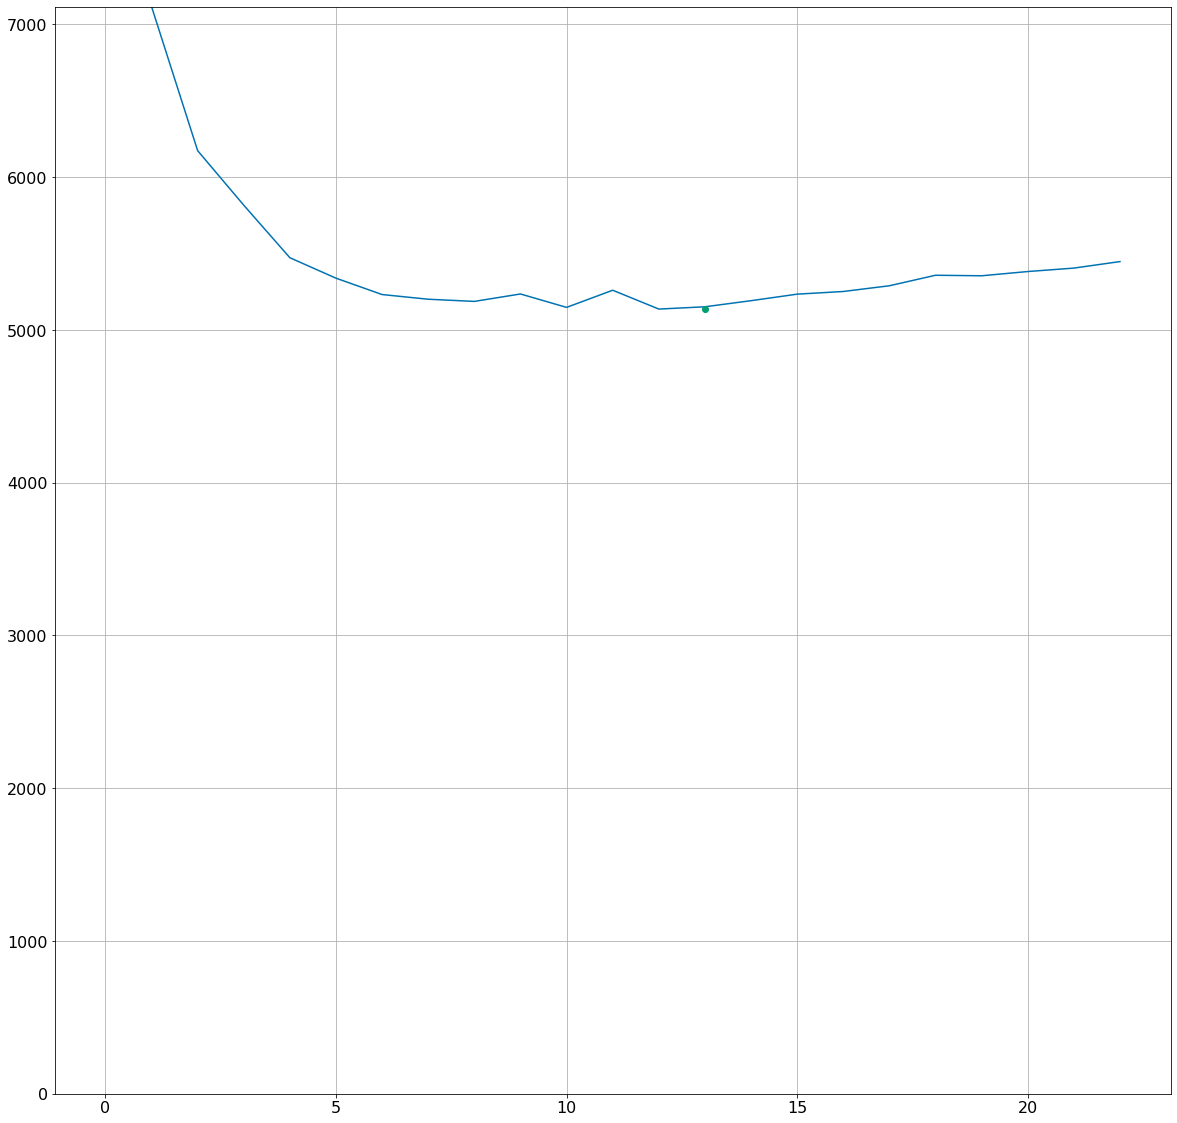

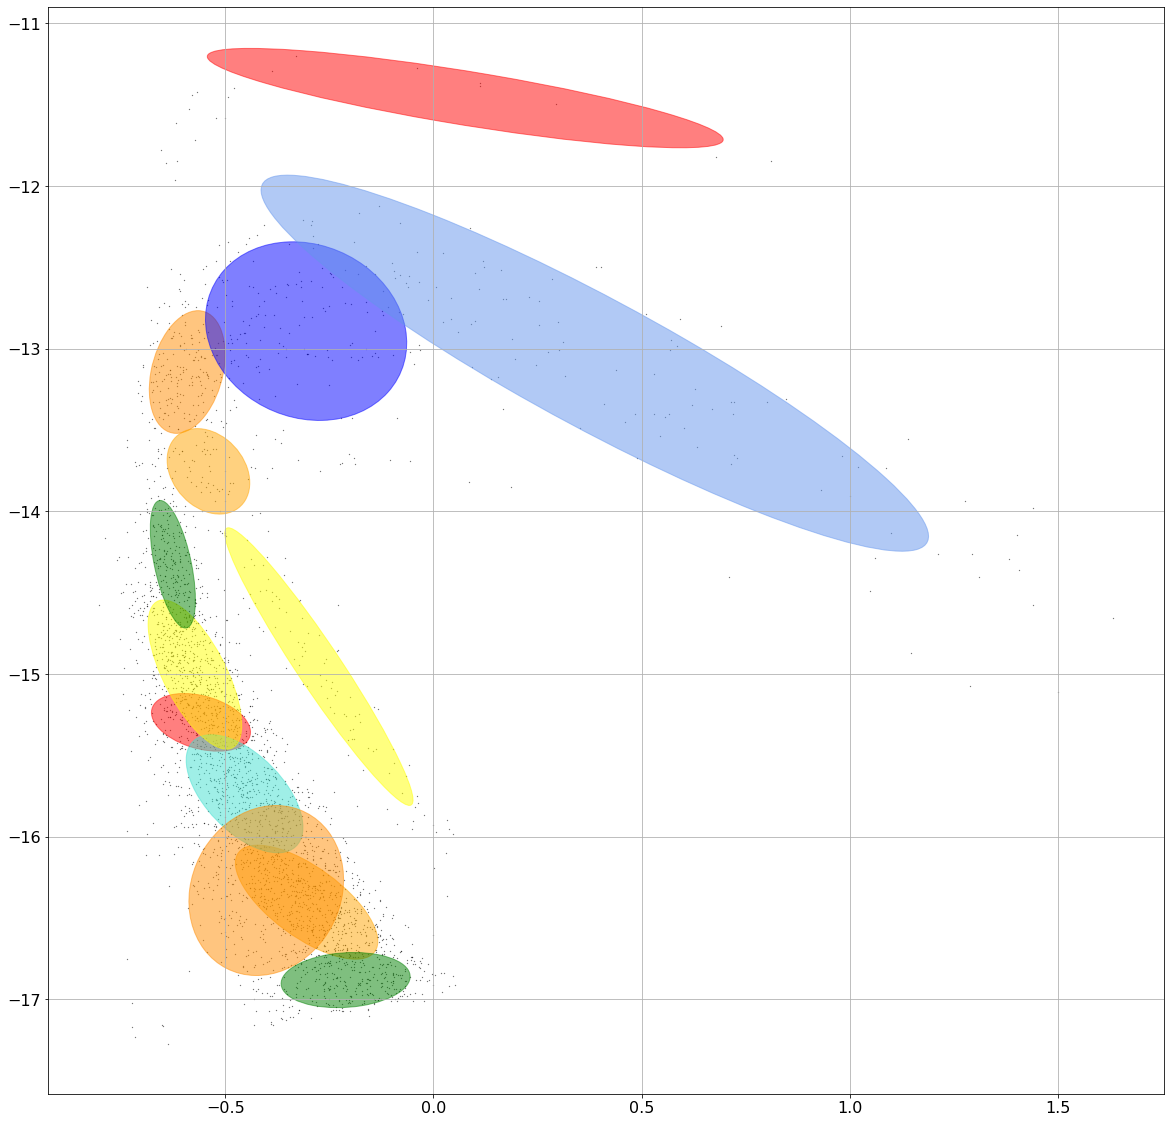

In [14]:
# plot BICs
BICsPlot= plt.figure()
ax = BICsPlot.add_subplot(1, 1, 1)
ax.set_ylim([0, max(BICs)])
plt.plot(list(range(0,len(BICs))),BICs)
plt.plot(shapeCount,BICs[shapeCount-1], 'o')
plt.grid()
plt.show()


# Plot the elipses
PrototypeHRTemplatePlot= plt.figure()
HRax = PrototypeHRTemplatePlot.add_subplot(1, 1, 1)
colorCycle = itertools.cycle(["red", "darkorange", "orange", "yellow", "green", "blue", "turquoise", "cornflowerblue"])
for i, (mean, cov, color) in enumerate(zip(HRModel.means_, HRModel.covariances_, colorCycle)):
    cov
    v, w = sp.linalg.eigh(cov)
    if not np.any(HRShapes == i):
        continue
    plt.scatter(allPoints_HRfloats[HRShapes == i, 0], allPoints_HRfloats[HRShapes == i, 1], 0.05, color='black')

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    # ell.set_clip_box(HRax.bbox)
    ell.set_alpha(0.5)
    HRax.add_artist(ell)
plt.grid()
plt.show()

### Initial clusters guess using BIC

In [11]:
tol=0.000 # plateau flatness tolerance
BICs=[999999]
farPoints_floats=farPointsNumpy[:,[1,2]].astype(np.float)
clusterCount = 1
clustersModel = mixture.GaussianMixture(n_components=clusterCount, covariance_type='full',n_init = 1)
clustersModel.fit(farPoints_floats)
minAge=0
reqMinAge=1
while minAge<reqMinAge:
    BIC=clustersModel.bic(farPoints_floats)
    if BIC<min(BICs):
        minAge=0
    else:
        minAge=minAge+1
    BICs.append(BIC)
    clusterCount=clusterCount+1
    clustersModel = mixture.GaussianMixture(n_components=clusterCount, covariance_type="full",n_init = 1)
    clustersModel.fit(farPoints_floats)
    
# select clusterCount
minBIC = min(BICs)
BICs.pop(0)
clusterCount = [i for i, e in enumerate(BICs) if e <= (minBIC*(1+tol))][0]+1
clustersModel = mixture.GaussianMixture(n_components=clusterCount, covariance_type="full",n_init = 1)
clusterShapes = clustersModel.fit_predict(farPoints_floats)

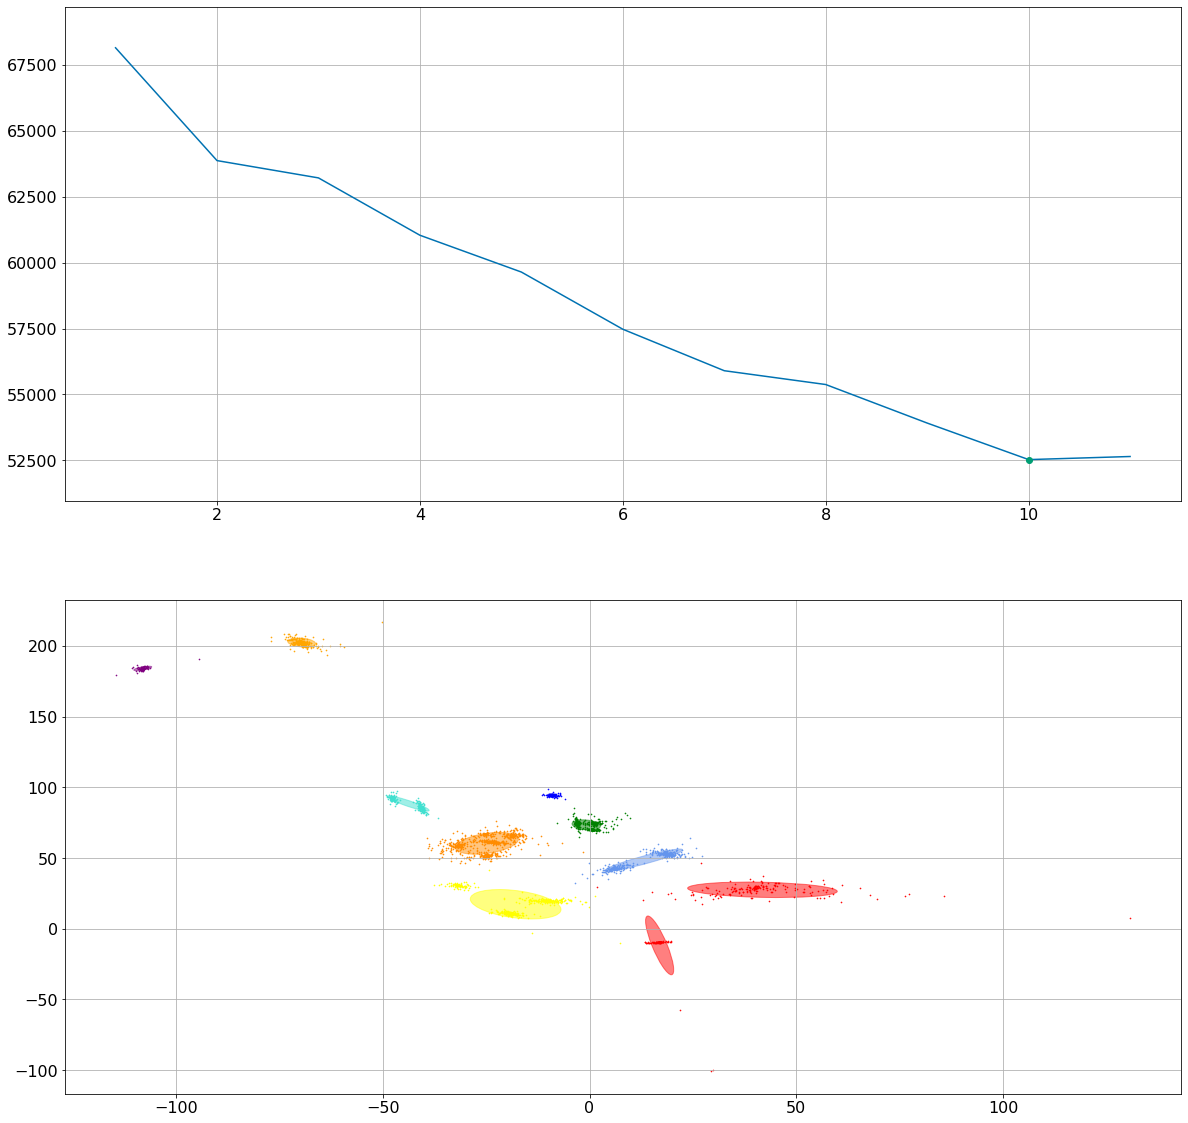

In [12]:


# plot BICs
ClusterFitPlot= plt.figure()
sp1 = plt.subplot(2, 1, 1)
ax = plt.gca()
ax.set_ylim([min(BICs)-0.1*(max(BICs)-min(BICs)), max(BICs)+0.1*(max(BICs)-min(BICs))])
plt.plot(list(range(1,len(BICs)+1)),BICs)
plt.plot(clusterCount,BICs[clusterCount-1], 'o')
plt.grid()



# Plot the elipses 1 by 1
sp2 = plt.subplot(2, 1, 2)
colorCycle = itertools.cycle(["red", "darkorange", "orange", "yellow", "green", "blue", "turquoise", "cornflowerblue", 'purple'])
for i, (mean, cov, color) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle)):
    v, w = sp.linalg.eigh(cov)
    if not np.any(clusterShapes == i):
        continue
    plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], 0.4, color= color)
#    plt.text(mean[0], mean[1], 'weight= ' + weight, fontsize=14)


    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(sp2.bbox)
    ell.set_alpha(0.5)
    sp2.add_artist(ell)
# for e in enumerate(zip(clustersModel.means_, clustersModel.weights_)):
#     plt.text(e[1][0][0], e[1][0][1], 'weight= ' + e[1][1].astype(str), fontsize=14)
plt.grid()    
plt.show()

### Iterate prototype HRtemplate for each cluster and exclude outliers
- Start with most isolated clusters

### Identify most isolated clusters